In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
import numpy.matlib
from PIL import Image
import PIL
from torchvision import transforms
import torch.nn.functional as F
from modules import *

from matplotlib import pyplot as plt
from unet import UNet
from resnet import ResNet
from torch.autograd import Variable
import cv2
import imageio

# Feature extraction

In [2]:
def featureL2Norm(feature):
    epsilon = 1e-6
    #        print(feature.size())
    #        print(torch.pow(torch.sum(torch.pow(feature,2),1)+epsilon,0.5).size())
    norm = torch.pow(torch.sum(torch.pow(feature,2),1)+epsilon,0.5).unsqueeze(1).expand_as(feature)
    return torch.div(feature,norm)

In [3]:

class FeatureExtraction(torch.nn.Module):
    def __init__(self, train_fe=False, feature_extraction_cnn='vgg', normalization=True, last_layer='', use_cuda=True):
        super(FeatureExtraction, self).__init__()
        self.normalization = normalization
        if feature_extraction_cnn == 'vgg':
            self.model = models.vgg16(pretrained=True)
            # keep feature extraction network up to indicated layer
            vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
            if last_layer=='':
                last_layer = 'pool4'
            last_layer_idx = vgg_feature_layers.index(last_layer)
            self.model = nn.Sequential(*list(self.model.features.children())[:last_layer_idx+1])
        if feature_extraction_cnn == 'resnet101':
            self.model = models.resnet101(pretrained=True)
            resnet_feature_layers = ['conv1',
                                     'bn1',
                                     'relu',
                                     'maxpool',
                                     'layer1',
                                     'layer2',
                                     'layer3',
                                     'layer4']
            if last_layer=='':
                last_layer = 'layer3'
            last_layer_idx = resnet_feature_layers.index(last_layer)
            resnet_module_list = [self.model.conv1,
                                  self.model.bn1,
                                  self.model.relu,
                                  self.model.maxpool,
                                  self.model.layer1,
                                  self.model.layer2,
                                  self.model.layer3,
                                  self.model.layer4]
            
            self.model = nn.Sequential(*resnet_module_list[:last_layer_idx+1])
        if feature_extraction_cnn == 'resnet101_v2':
            self.model = models.resnet101(pretrained=True)
            # keep feature extraction network up to pool4 (last layer - 7)
            self.model = nn.Sequential(*list(self.model.children())[:-3])
        if feature_extraction_cnn == 'densenet201':
            self.model = models.densenet201(pretrained=True)
            # keep feature extraction network up to denseblock3
            # self.model = nn.Sequential(*list(self.model.features.children())[:-3])
            # keep feature extraction network up to transitionlayer2
            self.model = nn.Sequential(*list(self.model.features.children())[:-4])
        if not train_fe:
            # freeze parameters
            for param in self.model.parameters():
                param.requires_grad = False
        # move to GPU
        if use_cuda:
            self.model = self.model.cuda()
        
    def forward(self, image_batch):
        features = self.model(image_batch)
        if self.normalization:
            features = featureL2Norm(features)
        return features

In [4]:
FeatureExtraction=FeatureExtraction(train_fe=False,
                                                   feature_extraction_cnn='vgg',
                                                   last_layer='pool2',
                                                   normalization=True,
                                                   use_cuda=True)


# Feature Correlation

In [5]:
  
class FeatureCorrelation(torch.nn.Module):
    def __init__(self,shape='3D',normalization=True,matching_type='correlation'):
        super(FeatureCorrelation, self).__init__()
        self.normalization = normalization
        self.matching_type=matching_type
        self.shape=shape
        self.ReLU = nn.ReLU()
    
    def forward(self, feature_A, feature_B):
        
        b,c,h,w = feature_A.size()
        
        if self.matching_type=='correlation':
            if self.shape=='3D':
                # reshape features for matrix multiplication
                feature_A = feature_A.transpose(2,3).contiguous().view(b,c,h*w)
                feature_B = feature_B.view(b,c,h*w).transpose(1,2)
                # perform matrix mult.
                feature_mul = torch.bmm(feature_B,feature_A)
                # indexed [batch,idx_A=row_A+h*col_A,row_B,col_B]
                correlation_tensor = feature_mul.view(b,h,w,h*w).transpose(2,3).transpose(1,2)
            elif self.shape=='4D':
                # reshape features for matrix multiplication
                feature_A = feature_A.view(b,c,h*w).transpose(1,2) # size [b,c,h*w]
                feature_B = feature_B.view(b,c,h*w) # size [b,c,h*w]
                # perform matrix mult.
                feature_mul = torch.bmm(feature_A,feature_B)
                # indexed [batch,row_A,col_A,row_B,col_B]
                correlation_tensor = feature_mul.view(b,h,w,h,w).unsqueeze(1)
            
            if self.normalization:
                correlation_tensor = featureL2Norm(self.ReLU(correlation_tensor))
        
            return correlation_tensor

        if self.matching_type=='subtraction':
            return feature_A.sub(feature_B)
        
        if self.matching_type=='concatenation':
            return torch.cat((feature_A,feature_B),1)

In [6]:
FeatureCorrelation = FeatureCorrelation(shape='3D',normalization=True,matching_type='correlation')        

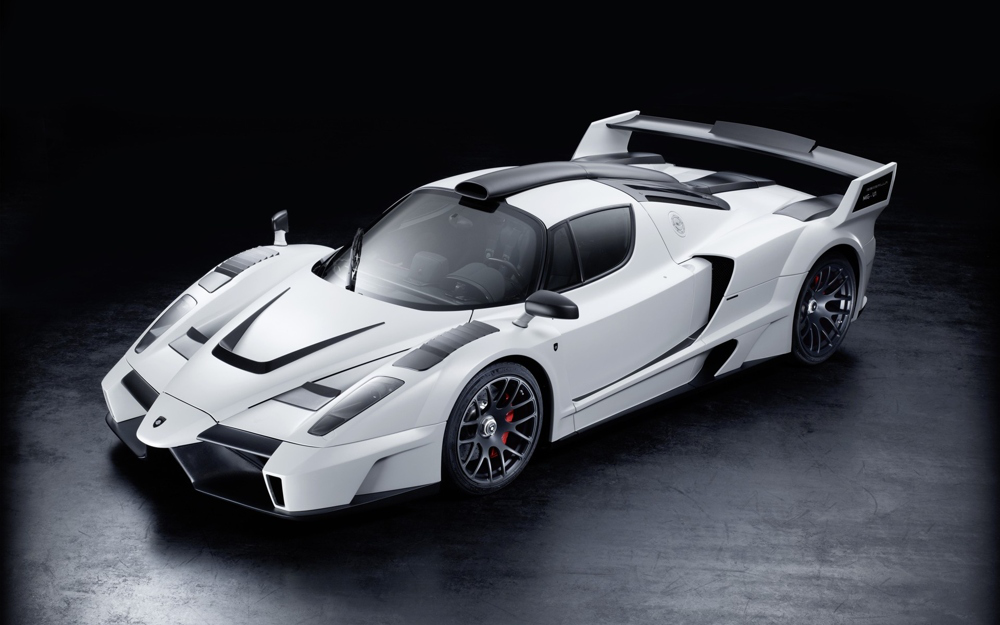

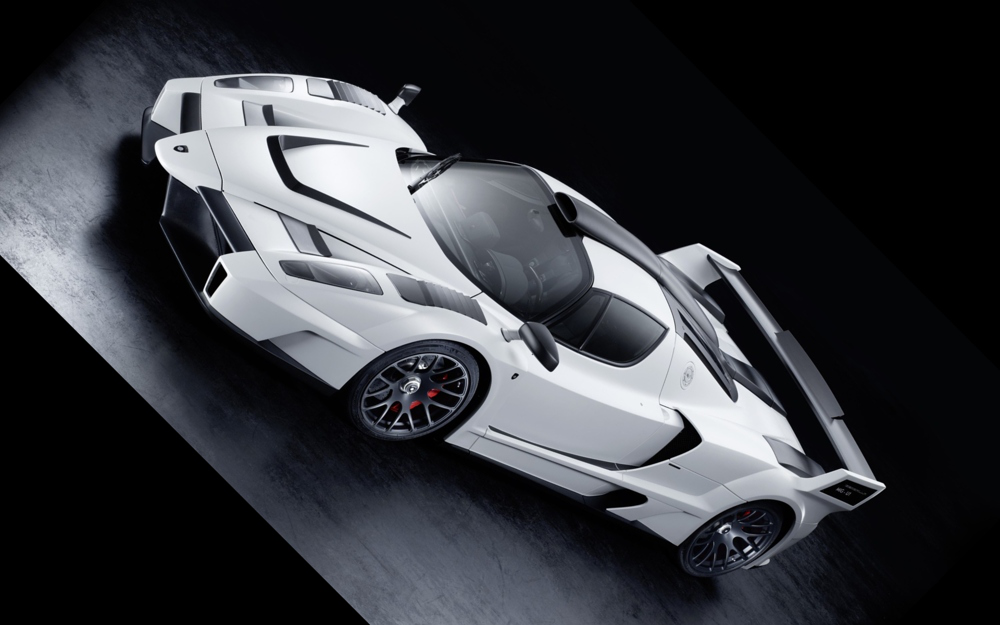

In [46]:
image1 = Image.open("_original.jpg");
image2 = Image.open("rotation3.jpg");
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
I1=transform(image1)
I2=transform(image2)
I1=I1.unsqueeze(dim=0)
I2=I2.unsqueeze(dim=0)
I1,I2=I1.cuda(),I2.cuda()
display(image1)
display(image2)



In [47]:
feature_A = FeatureExtraction(I1)
feature_B = FeatureExtraction(I2)
        # feature correlation
correlation = FeatureCorrelation(feature_A,feature_B)

In [48]:
c,w,h=feature_A.shape[1],feature_A.shape[2],feature_A.shape[3]
print(feature_A.shape)
Matching_field=torch.zeros(2,w,h).unsqueeze(dim=0)
Matching_field.shape

torch.Size([1, 128, 64, 64])


torch.Size([1, 2, 64, 64])

# COrrelation + matching field

In [10]:
#Matching field 
a=torch.argmax(correlation,dim=1)
a=a.squeeze()
Matching_field=torch.zeros(2,w,h)
for k in range(2):
    for i in range(h):
        for j in range(h):
            if k==0:
                Matching_field[k][i][j]=int(a[i][j]/h)-i
            elif k==1:
                Matching_field[k][i][j]=int(a[i][j]%h)-j
                
                

Matching_field_upsample=F.interpolate(input=Matching_field.unsqueeze(dim=0), size=(256,256), mode='bilinear')
Matching_field=Matching_field/Matching_field.size(2)
Matching_field_upsample=Matching_field_upsample.squeeze()
Matching_field_upsample=Matching_field_upsample/Matching_field_upsample.size(1)

Matching_field=Matching_field.unsqueeze(dim=0).transpose(1,2).transpose(2,3)
Matching_field_upsample=Matching_field_upsample.unsqueeze(dim=0).transpose(1,2).transpose(2,3)


/opt/conda/conda-bld/pytorch_1591914858187/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
/home/ubuntu03/anaconda3/envs/first_env/lib/python3.8/site-packages/torch/nn/functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


/home/ubuntu03/anaconda3/envs/first_env/lib/python3.8/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


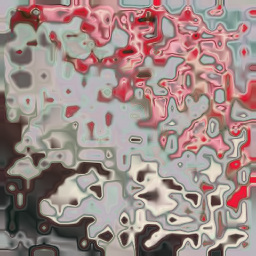

<PIL.Image.Image image mode=RGB size=256x256 at 0x7FBCF04BE820>
(256, 256)


In [11]:
#Displacement (change in x and change in y + divide by width or height size to scale to [-1 1])
Warped_feature=F.grid_sample(feature_A,Matching_field.cuda())
Warped_image=F.grid_sample(I2,Matching_field_upsample.cuda())
# How should I upsample this warped feature to image level?
#1. interpolate (cannot account for channel) 2. upconv (Image A - Warped Image as a loss to train upconv filter)
Warped_image=Warped_image.squeeze()
im = transforms.ToPILImage()(Warped_image.cpu()).convert("RGB")
display(im)
print(im)
print(im.size)

In [12]:
#Matching field 
a=torch.argmax(correlation,dim=1)
a=a.squeeze()
Matching_field=torch.zeros(2,w,h)
for k in range(2):
    for i in range(h):
        for j in range(h):
            if k==0:
                Matching_field[k][i][j]=int(a[i][j]/h)
            elif k==1:
                Matching_field[k][i][j]=int(a[i][j]%h)
                
                

Matching_field_upsample=F.interpolate(input=Matching_field.unsqueeze(dim=0), size=(256,256), mode='bilinear')
Matching_field=2*(Matching_field-torch.min(Matching_field))/(torch.max(Matching_field)-torch.min(Matching_field))-1
Matching_field_upsample=Matching_field_upsample.squeeze()
Matching_field_upsample=2*(Matching_field_upsample-torch.min(Matching_field_upsample))/(torch.max(Matching_field_upsample)-torch.min(Matching_field_upsample))-1

Matching_field=Matching_field.unsqueeze(dim=0).transpose(1,2).transpose(2,3)
Matching_field_upsample=Matching_field_upsample.unsqueeze(dim=0).transpose(1,2).transpose(2,3)


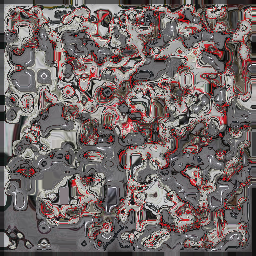

<PIL.Image.Image image mode=RGB size=256x256 at 0x7FBCF0D38F10>
(256, 256)


In [13]:
Warped_feature=F.grid_sample(feature_A,Matching_field.cuda())
Warped_image=F.grid_sample(I2,Matching_field_upsample.cuda())
# How should I upsample this warped feature to image level?
#1. interpolate (cannot account for channel) 2. upconv (Image A - Warped Image as a loss to train upconv filter)
Warped_image=Warped_image.squeeze()
im = transforms.ToPILImage()(Warped_image.cpu()).convert("RGB")
display(im)
print(im)
print(im.size)
#number 1 correlation

# number 2

In [14]:

def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'ResNet':
        # TODO
        net = ResNet(input_depth, 2, 10, 16, 1, nn.BatchNorm2d, False)
    elif NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11, 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)

    elif NET_TYPE == 'texture_nets':
        net = get_texture_nets(inp=input_depth, ratios = [32, 16, 8, 4, 2, 1], fill_noise=False,pad=pad)

    elif NET_TYPE =='UNet':
        net = UNet(num_input_channels=input_depth, num_output_channels=2, 
                   feature_scale=4, more_layers=0, concat_x=False,
                   upsample_mode=upsample_mode, pad=pad, norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True)
    elif NET_TYPE == 'identity':
        assert input_depth == 3
        net = nn.Sequential()
    else:
        assert False

    return net

In [15]:
def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)
        
        fill_noise(net_input, noise_type)
        net_input *= var            
    elif method == 'meshgrid': 
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False
        
    return net_input

In [16]:
#Closure is for loss
dtype = torch.cuda.FloatTensor
mse = torch.nn.MSELoss().type(dtype)
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

In [17]:
#(x-min(x))/(max(x)-min(x))
def closure():
    global i
    out=net(net_input)
    
    Matching_image_field=F.interpolate(input=out, size=(224,224), mode='bilinear')
    Matching_feature_field=F.interpolate(input=out, size=(w,h), mode='bilinear')
   
    Matching_image_field[:,0,:,:]=2*Matching_image_field[:,0,:,:]-1
    Matching_image_field[:,1,:,:]=2*Matching_image_field[:,1,:,:]-1
    Matching_image_field=Matching_image_field.transpose(1,2).transpose(2,3)
    Warped_image=F.grid_sample(I1,Matching_image_field.cuda())
    
   
    Matching_feature_field[:,0,:,:]=2*Matching_feature_field[:,0,:,:]-1
    Matching_feature_field[:,1,:,:]=2*Matching_feature_field[:,1,:,:]-1
    Matching_feature_field=Matching_feature_field.transpose(1,2).transpose(2,3)
    Warped_feature=F.grid_sample(feature_A,Matching_feature_field.cuda())
    
    
    loss_1=mse(I2,Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
    i += 1
    return total_loss
    

In [18]:
#(x-min(x))/(max(x)-min(x))
def closure_resized():
    global i
    out=net(net_input)
    
    Matching_image_field=F.interpolate(input=out, size=(56,56), mode='bilinear')
    Matching_feature_field=F.interpolate(input=out, size=(w,h), mode='bilinear')
    
    Matching_image_field[:,0,:,:]=2*Matching_image_field[:,0,:,:]-1
    Matching_image_field[:,1,:,:]=2*Matching_image_field[:,1,:,:]-1
    Matching_image_field=Matching_image_field.transpose(1,2).transpose(2,3)
    Warped_image=F.grid_sample(I1_resize.cuda(),Matching_image_field.cuda())
    
   
    Matching_feature_field[:,0,:,:]=2*Matching_feature_field[:,0,:,:]-1
    Matching_feature_field[:,1,:,:]=2*Matching_feature_field[:,1,:,:]-1
    Matching_feature_field=Matching_feature_field.transpose(1,2).transpose(2,3)
    Warped_feature=F.grid_sample(feature_A,Matching_feature_field.cuda())
    
    
    loss_1=mse(I2_resize,Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
    i += 1
    return total_loss
    

In [19]:
def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

In [29]:
transform_resize=transforms.Compose([transforms.Resize((w*2,w*2)), transforms.ToTensor()])
I1_resize=transform_resize(image1)
I2_resize=transform_resize(image2)
I1_resize=I1_resize.unsqueeze(dim=0)
I2_resize=I2_resize.unsqueeze(dim=0)
I1_resize,I2_resize=I1_resize.cuda(),I2_resize.cuda()
print(I1_resize.shape)

torch.Size([1, 3, 64, 64])


In [36]:
dtype = torch.cuda.FloatTensor
mse = torch.nn.MSELoss().type(dtype)
i=0
net=get_net(w,'UNet',pad='zero',upsample_mode='bilinear').cuda()

net_input=get_noise(w, 'noise', feature_A[0,0,:].shape,noise_type='n').type(dtype).cuda()

p = get_params('net', net, net_input)
optimize('adam', p, closure_resized, 0.00001, 10000)

zero
zero
zero
zero
zero
zero
zero
zero
zero
Starting optimization with ADAM


In [20]:
def remap_using_correspondence_map(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT):
    """
    opencv remap : carefull here mapx and mapy contains the index of the future position for each pixel
    not the displacement !
    map_x contains the index of the future horizontal position of each pixel [i,j] while map_y contains the index of the future y
    position of each pixel [i,j]
    All are numpy arrays
    :param image: image to remap, HxWxC
    :param disp_x: displacement on the horizontal direction to apply to each pixel. must be float32. HxW
    :param disp_y: isplacement in the vertical direction to apply to each pixel. must be float32. HxW
    :return:
    remapped image. HxWxC
    """
   

    # estimate the grid
   
    
    remapped_image = cv2.remap(image, map_x, map_y, interpolation=interpolation, borderMode=border_mode)

    return remapped_image

Text(0.5, 1.0, 'target image')

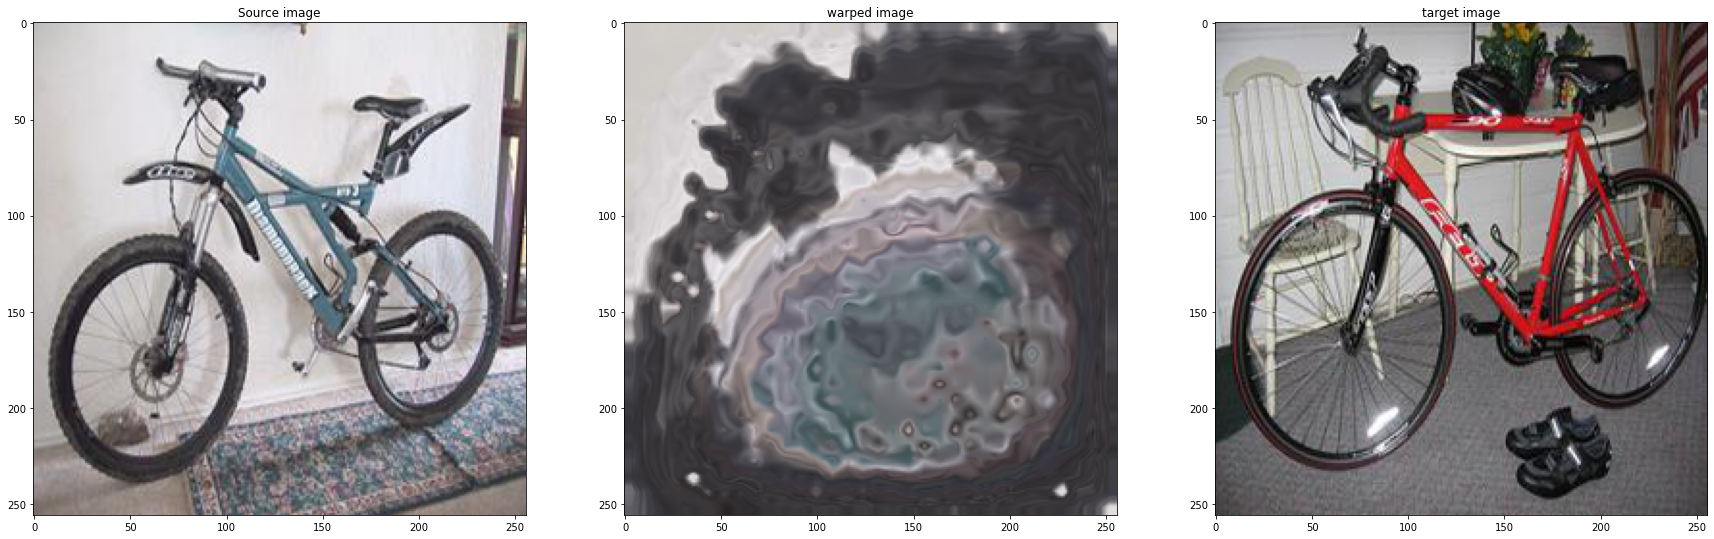

In [37]:
image=imageio.imread('src.jpg')
image2=imageio.imread('tgt.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
matching=net(net_input)


matching=F.interpolate(matching,size=(224,224),mode='bilinear')
matching[:,0,:,:]=223*matching[:,0,:,:]
matching[:,1,:,:]=223*matching[:,1,:,:]
warped_image=remap_using_correspondence_map(image,matching.squeeze()[0].detach().cpu().numpy(),matching.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


Text(0.5, 1.0, 'target image')

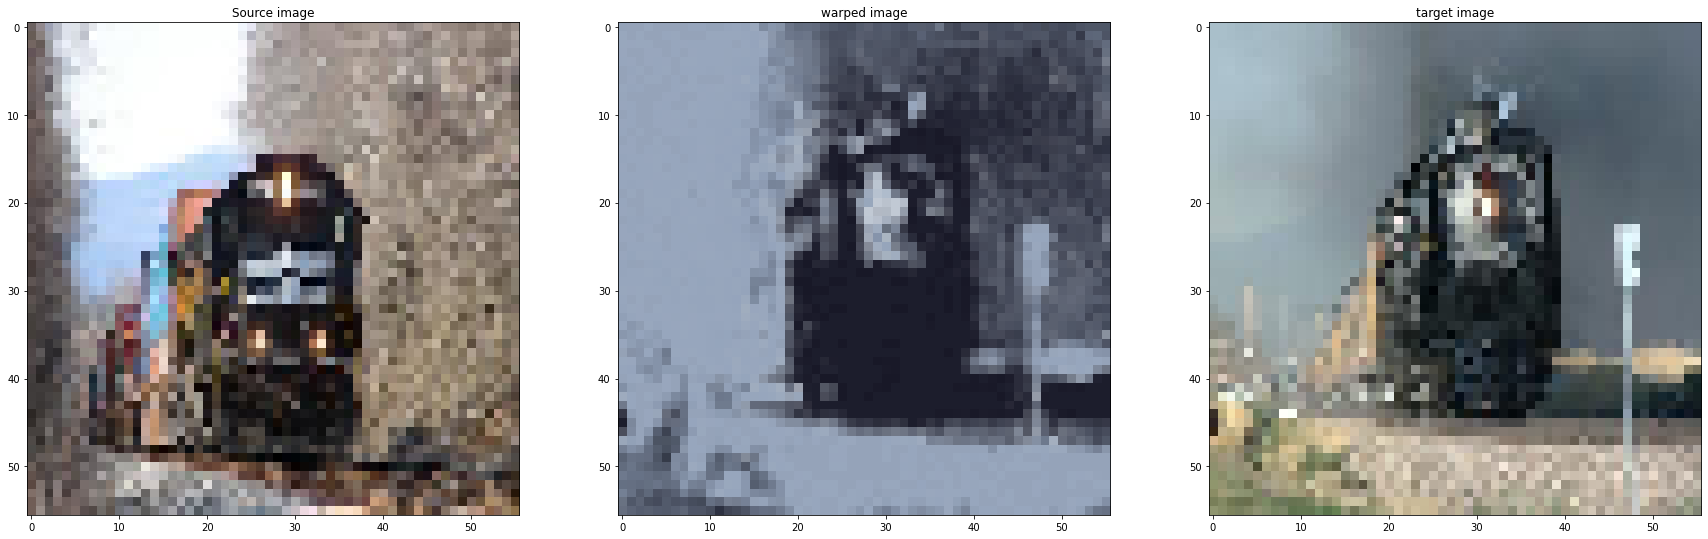

In [43]:
image=imageio.imread('src4.jpg')
image2=imageio.imread('tgt4.jpg')
image=cv2.resize(image, dsize=(56,56 ), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(56,56 ), interpolation=cv2.INTER_CUBIC)
matching=net(net_input)


matching=F.interpolate(matching,size=(56,56 ),mode='bilinear')
matching[:,0,:,:]=(56-1)*matching[:,0,:,:]
matching[:,1,:,:]=(56-1)*matching[:,1,:,:]
warped_image=remap_using_correspondence_map(image,matching.squeeze()[0].detach().cpu().numpy(),matching.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


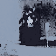

<PIL.Image.Image image mode=RGB size=56x56 at 0x7FE6A4170C40>
(56, 56)


In [45]:

matching=net(net_input)
matching=F.interpolate(matching,size=(56,56),mode='bilinear')
matching[:,0,:,:]=2*matching[:,0,:,:]-1
matching[:,1,:,:]=2*matching[:,1,:,:]-1

matching=matching.transpose(1,2).transpose(2,3)
Warped=F.grid_sample(I1,matching.cuda()).squeeze()

im = transforms.ToPILImage()(Warped.cpu()).convert("RGB")
display(im)
print(im)
print(im.size)
#number 2 0.9 image loss + 0.1 feature loss


# Number 3 -> without contrastive learning let's try with feature extractor included in the training process

In [26]:
#contrastive learning(Each feature map, which pixel or location should i consider as positive?)
#optimize and loss for contrastive how do i separate? (every maybe 1000 epochs, use the optimized theta and do the training)
#deconv ?

# not training with a dataset . So no need for dataloader... 
# Then feature extraction -> warp feature(rough) ->(upsample? easy, but deconv? each layer each loss) 
# -> optimize(maybe 1000?) -> updated parameter for matching field 
# -> warped feature
# for epoch :
# feature extraction 
# optimize (DIP)
# matching field by net(input noise)
# 

In [58]:
model=models.vgg16(pretrained=False)

last_layer='pool3'
model = models.vgg16(pretrained=False)
            # keep feature extraction network up to indicated layer
vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
if last_layer=='':
        last_layer = 'pool4'
last_layer_idx = vgg_feature_layers.index(last_layer)
model = nn.Sequential(*list(model.features.children())[:last_layer_idx+1])
model.cuda()
f1=model(I1)
c,w,h=f1.shape[1],f1.shape[2],f1.shape[3]
net=get_net(w,'UNet',pad='zero',upsample_mode='bilinear').cuda()
net_input=get_noise(w, 'noise', f1[0,0,:].shape).type(dtype).cuda()
optimizer=torch.optim.Adam(net.parameters(),0.0001)
optimizer_feature=torch.optim.Adam(model.parameters(),0.0001)

zero
zero
zero
zero
zero
zero
zero
zero
zero


In [59]:
# pos logit
   #     l_pos = torch.bmm(feat_q.view(batchSize, 1, -1), feat_k.view(batchSize, -1, 1))
    #    l_pos = l_pos.view(batchSize, 1)

In [60]:
#Training step
global i 
i=0
total_loss=0
for epoch in range(5000):
    feature_A = model(I1)
    feature_B = model(I2)
    
    feature_A = featureL2Norm(feature_A)
    feature_B = featureL2Norm(feature_B)
   
    out=net(net_input)  
    Matching_image_field=F.interpolate(input=out, size=(256,256), mode='bilinear')
    Matching_feature_field=F.interpolate(input=out, size=(w,h), mode='bilinear')
    
    Matching_image_field[:,0,:,:]=2*Matching_image_field[:,0,:,:]-1
    Matching_image_field[:,1,:,:]=2*Matching_image_field[:,1,:,:]-1
    Matching_image_field=Matching_image_field.transpose(1,2).transpose(2,3)
    Warped_image=F.grid_sample(I1,Matching_image_field.cuda())
    
    Matching_feature_field[:,0,:,:]=2*Matching_feature_field[:,0,:,:]-1
    Matching_feature_field[:,1,:,:]=2*Matching_feature_field[:,1,:,:]-1
    Matching_feature_field=Matching_feature_field.transpose(1,2).transpose(2,3)
    Warped_feature=F.grid_sample(feature_A,Matching_feature_field.cuda())
    
    
    
    loss_1=mse(I2,Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    total_loss.backward(retain_graph=True)
    
    
    optimizer_feature.zero_grad()
    optimizer.zero_grad()
    total_loss.backward()
    optimizer_feature.step()
    optimizer.step()
    print ('Iteration %05d    Loss %.10f' % (i, total_loss.item()), '\r', end='')
    if  i % 1000 == 0:
        
        print(loss_2)
        
    i += 1
    

tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9958e-09, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2575e-10, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6805e-10, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.1006e-10, device='cuda:0', grad_fn=<MeanBackward0>)


Text(0.5, 1.0, 'target image')

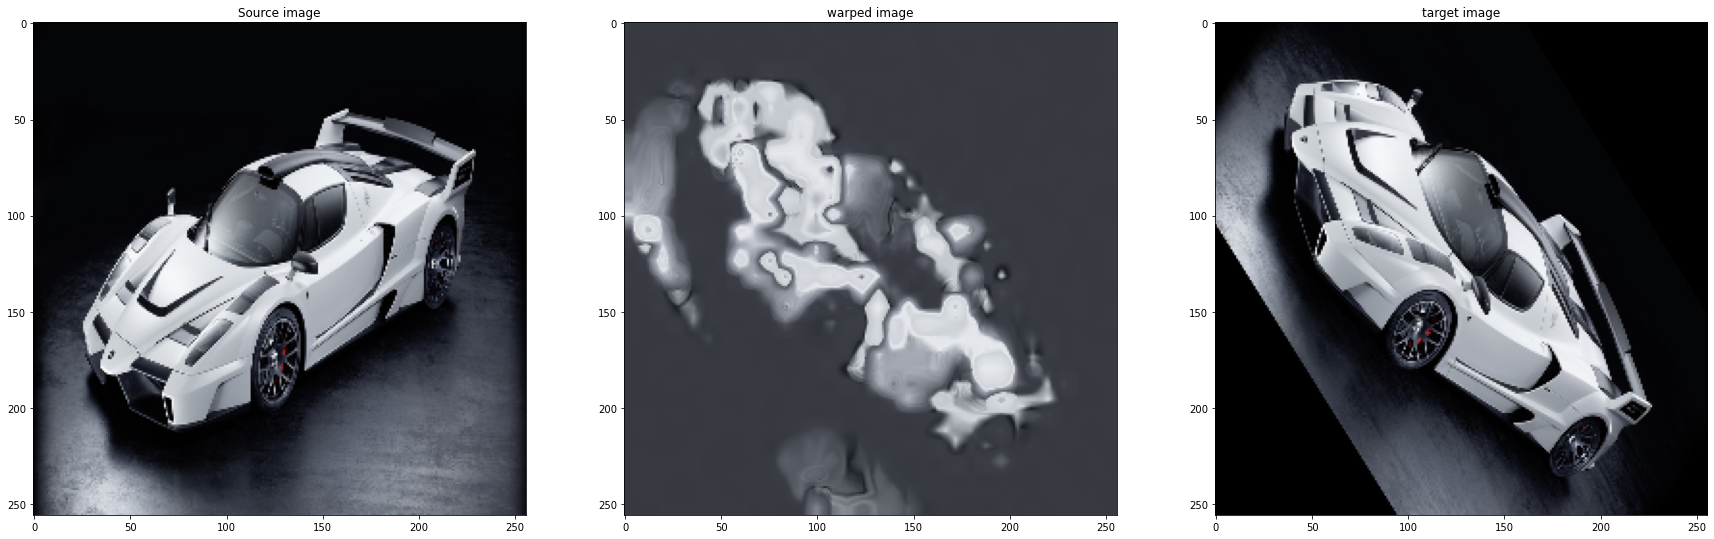

In [61]:
#256
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
matching=net(net_input)


matching=F.interpolate(matching,size=(256,256),mode='bilinear')
matching[:,0,:,:]=255*matching[:,0,:,:]
matching[:,1,:,:]=255*matching[:,1,:,:]
warped_image=remap_using_correspondence_map(image,matching.squeeze()[0].detach().cpu().numpy(),matching.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


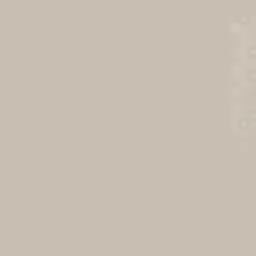

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F529215F610>
(256, 256)


In [152]:

matching=net(net_input)
matching=F.interpolate(matching,size=(256,256),mode='bilinear')
matching[:,0,:,:]=2*matching[:,0,:,:]-1
matching[:,1,:,:]=2*matching[:,1,:,:]-1
matching=matching.transpose(1,2).transpose(2,3)
Warped=F.grid_sample(I1,matching.cuda()).squeeze()

im = transforms.ToPILImage()(Warped.cpu()).convert("RGB")
display(im)
print(im)
print(im.size)
#number 2 0.9 image loss + 0.1 feature loss


# number 4

contrastive Learning included

In [53]:
# A B (1,256,256)
class PatchNCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
        self.mask_dtype = torch.bool #if version.parse(torch.__version__) < version.parse('1.2.0') else torch.bool

    def forward(self, feat_q, feat_k):
        batchSize = feat_q.shape[0]
        dim = feat_q.shape[1]
        feat_k = feat_k.detach()
        
        # pos logit
        l_pos = torch.bmm(feat_q.view(batchSize, 1, -1), feat_k.view(batchSize, -1, 1))
        l_pos = l_pos.view(batchSize, 1)
        
        # neg logit -- current batch
        # reshape features to batch size
        feat_q = feat_q.view(1, -1, dim)
        
        feat_k = feat_k.view(1, -1, dim)
        npatches = feat_q.size(1)
        l_neg_curbatch = torch.bmm(feat_q, feat_k.transpose(2, 1))
        
        # diagonal entries are similarity between same features, and hence meaningless.
        # just fill the diagonal with very small number, which is exp(-10) and almost zero
        diagonal = torch.eye(npatches, device=feat_q.device, dtype=self.mask_dtype)[None, :, :]
        l_neg_curbatch.masked_fill_(diagonal, -10.0)
        l_neg = l_neg_curbatch.view(-1, npatches)
        
        
        
        out = torch.cat((l_pos, l_neg), dim=1) / 0.07
        
        loss = self.cross_entropy_loss(out, torch.zeros(out.size(0), dtype=torch.long,
                                                        device=feat_q.device))
       
        return loss
#torch.Size([1, 1024, 256]) == feat_q
#torch.Size([1, 1, 262144]) == lpos

#1 256 1 

In [54]:
#set up


last_layer='pool3'
model = models.vgg16(pretrained=False)
            # keep feature extraction network up to indicated layer
vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
if last_layer=='':
        last_layer = 'pool4'
last_layer_idx = vgg_feature_layers.index(last_layer)
model = nn.Sequential(*list(model.features.children())[:last_layer_idx+1])
model.cuda()
f1=model(I1)
c,w,h=f1.shape[1],f1.shape[2],f1.shape[3]
input_nc=c
nc=256

mlp = nn.Sequential(*[nn.Linear(input_nc, nc), nn.ReLU(), nn.Linear(nc, nc)]).cuda()
net=get_net(w,'UNet',pad='zero',upsample_mode='bilinear').cuda()
net_input=get_noise(w, 'noise', f1[0,0,:].shape).type(dtype).cuda()
optimizer=torch.optim.Adam(net.parameters(),0.00001)
optimizer_feature=torch.optim.Adam(model.parameters(),0.00001)


PatchNCE=PatchNCELoss()

#channel = 256

zero
zero
zero
zero
zero
zero
zero
zero
zero


In [55]:
#Training step
#feat = B X  C X H X W
global i 
i=0
for epoch in range(5000):
    
    feature_B = model(I2)
    
    
    # took out l2 norm for feature
    
    featB_reshape = feature_B.permute(0, 2, 3, 1).flatten(1, 2)
    patch_id = torch.randperm(featB_reshape.shape[1]).cuda()
    patch_id = patch_id[:int(min(256, patch_id.shape[0]))]  # .to(patch_ids.device)
    B_sample = featB_reshape[:, patch_id, :].flatten(0, 1)  # reshape(-1, x.shape[1])
   
    
    B=mlp(B_sample)
    B=featureL2Norm(B)
    out=net(net_input)  
    Matching_image_field=F.interpolate(input=out, size=(256,256), mode='bilinear')
    
    Matching_image_field[:,0,:,:]=2*Matching_image_field[:,0,:,:]-1
    Matching_image_field[:,1,:,:]=2*Matching_image_field[:,1,:,:]-1
    Matching_image_field=Matching_image_field.transpose(1,2).transpose(2,3)
    Warped_image=F.grid_sample(I1,Matching_image_field.cuda())
      
    
   
    featA_reshape=model(Warped_image).permute(0,2,3,1).flatten(1,2)
    A_sample= featA_reshape[:,patch_id,:].flatten(0,1)
    
    A=mlp(A_sample)
    A=featureL2Norm(A)
   
   
    loss_1=mse(I2,Warped_image)
    loss_2=PatchNCE(A,B).mean()
    print ('Iteration %05d    Loss %f' % (i, loss_2), '\r', end='')
    
    total_loss=loss_1+loss_2
    total_loss.backward(retain_graph=True)
    if  i % 1000 == 0:
        print(loss_1)
        print(loss_2)
    
    optimizer_feature.zero_grad()
    optimizer.zero_grad()
    total_loss.backward()
    optimizer_feature.step()
    optimizer.step()
   #print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
    i += 1
    

tensor(0.1091, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5495, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0672, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.1078, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0660, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5695, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)


Text(0.5, 1.0, 'target image')

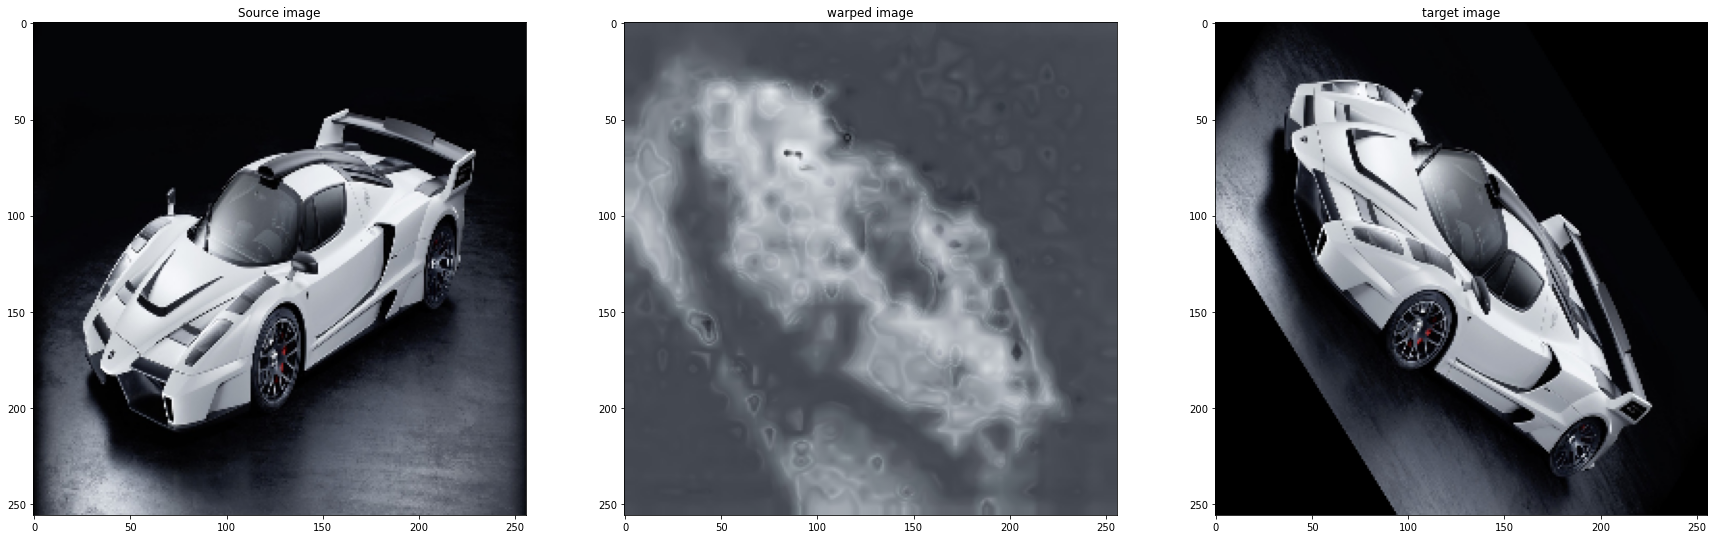

In [57]:
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
matching=net(net_input)


matching=F.interpolate(matching,size=(256,256),mode='bilinear')
matching[:,0,:,:]=255*matching[:,0,:,:]
matching[:,1,:,:]=255*matching[:,1,:,:]
warped_image=remap_using_correspondence_map(image,matching.squeeze()[0].detach().cpu().numpy(),matching.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


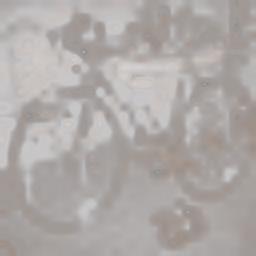

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F534695FBE0>
(256, 256)


In [74]:
matching=net(net_input)
matching=F.interpolate(matching,size=(256,256),mode='bilinear')

matching[:,0,:,:]=2*matching[:,0,:,:]-1
matching[:,1,:,:]=2*matching[:,1,:,:]-1
matching=matching.transpose(1,2).transpose(2,3)
Warped=F.grid_sample(I1,matching.cuda()).squeeze()

im = transforms.ToPILImage()(Warped.cpu()).convert("RGB")
display(im)
print(im)
print(im.size)
#number 2 0.9 image loss + 0.1 feature loss
